# Formula 1 Modelling Regression

In [137]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import plotly.express as px

from scripts.ds_ultils import *
from scripts.fastf1_data_download import *
from scripts.model_ultils import *
plt.style.use('./scripts/plotstyle.mplstyle')
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score ,mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report, plot_roc_curve,roc_auc_score
from sklearn.feature_selection import SelectKBest, SelectFromModel
from mlxtend.feature_selection import ColumnSelector
from sklearn.model_selection import (GridSearchCV, RandomizedSearchCV,
                                     cross_val_score, train_test_split)
import joblib
from xgboost import XGBRegressor

In [2]:
qualify_df=pd.read_pickle('./data/model_data/formula1_complete_2018_2022.pkl',compression='gzip')
qualifying_df=qualify_df.copy()
qualifying_df.dropna(inplace=True)
X_test, X_train, y_test, y_train = prepare_modelling_df(qualifying_df)
ypos_train=y_train['quali_position'].copy()
ypos_test=y_test['quali_position'].copy()
ydelta_train=abs(y_train['lap_timedelta_milliseconds'].copy())
ydelta_test=abs(y_test['lap_timedelta_milliseconds'].copy()


In [409]:
Results_summary=[]

## Manual Feature Selection

In [3]:
feature_importance=pd.read_pickle('./data/model_data/feature_importance_results.pkl')
manual_features = list(feature_importance[feature_importance['Random_forest_result']>0.8].index)
features_remove =[ 'numerical_transform__avglap_Sector1',
 'numerical_transform__avglap_Sector2',
 'numerical_transform__avglap_Sector3',
 'numerical_transform__max_max_rpm',
 'numerical_transform__mean_var_straight_rpm',
 'numerical_transform__mean_straight_rpm' ]
manual_features = [x for x in manual_features if x not in features_remove]
X_train_manual, X_test_manual = apply_manual_features(X_train,X_test,features=manual_features)
scale_cols, hot_encode_col = column_lists(X_train_manual)

In [412]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
linear_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('linear_regression',LinearRegression())# classifier
        
]
linear_pipe=Pipeline(linear_estimator)

In [413]:
linear_pos= linear_pipe.fit(X_train_manual,ypos_train)
pos_predictions=linear_pos.predict(X_test_manual)
print(f'Position Linear regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Linear regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

linear_delta= linear_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=linear_delta.predict(X_test_manual)
print(f'Lap Delta Linear regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Linear regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')
Results_summary.append(pd.DataFrame({'Model':'LinearRegression',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions)},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'LinearRegression',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions)},index=[0]))


Position Linear regression Initial R2 score with manual selected featuers 0.5778725086642211
Position Linear regression Initial MAE score with manual selected feaure 2.8926478794642856
Lap Delta Linear regression Initial R2 score with manual selected featuers -29.32355618911363
Lap Delta Linear regression Initial MAE score with manual selected feaure 1200.3048469387754


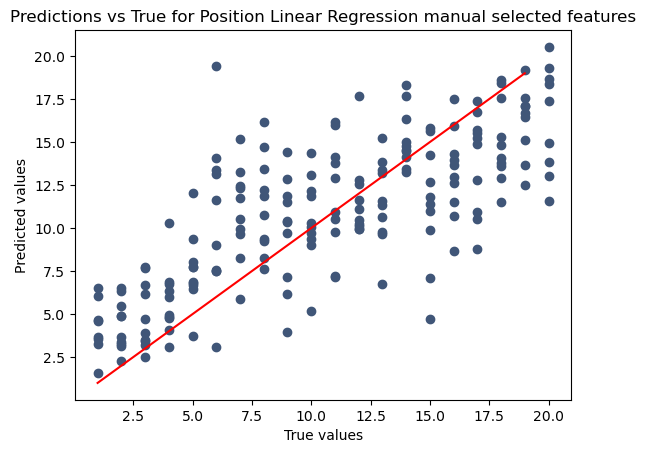

In [414]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Linear Regression manual selected features')
plt.show()

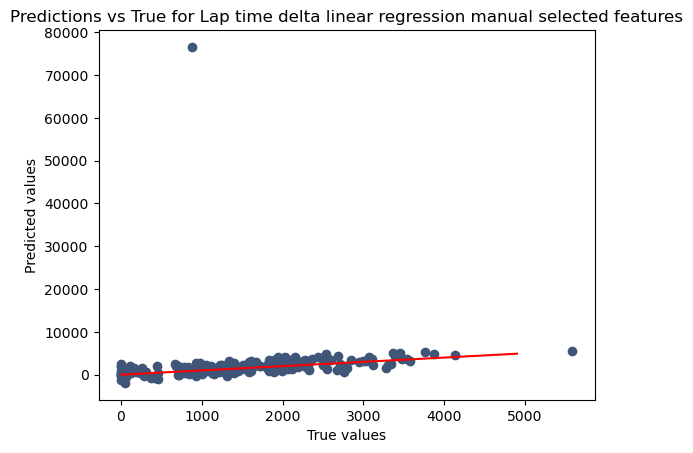

In [415]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta linear regression manual selected features')
plt.show()

## Random Forest Regression

In [416]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [417]:
forest_pos= forest_pipe.fit(X_train_manual,ypos_train)
pos_predictions=forest_pos.predict(X_test_manual)
print(f'Position Random Forest regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
forest_delta= forest_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=forest_delta.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position Random Forest regression Initial R2 score with manual selected featuers 0.6200971716696152
Position Random Forest regression Initial MAE score with manual selected feaure 2.742040816326531
Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.6948116027227405
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 433.6388265306122


In [418]:
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions)},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions)},index=[0]))

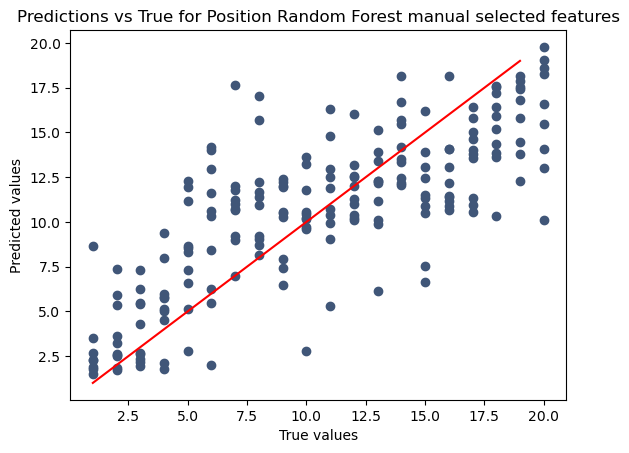

In [90]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Random Forest manual selected features')
plt.show()

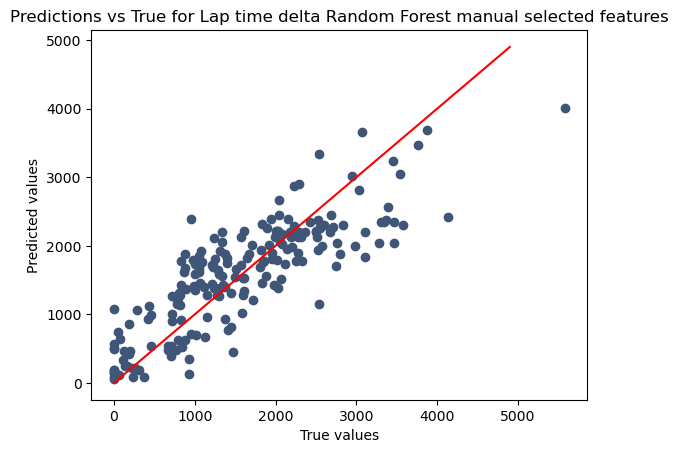

In [91]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest manual selected features')
plt.show()

## Automatic Select Features 

In [419]:
transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]
#selector = [('column_selector','passthrough',manual_features)]
random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('select_from_model',SelectFromModel(RandomForestRegressor(),threshold=-np.inf,max_features=70)),
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [420]:
forest_pos= forest_pipe.fit(X_train,ypos_train)
pos_predictions=forest_pos.predict(X_test)
print(f'Position Random Forest regression Initial R2 score with auto selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with auto selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
forest_delta= forest_pipe.fit(X_train,ydelta_train)
delta_predictions=forest_delta.predict(X_test)
print(f'Lap Delta Random Forest regression Initial R2 score with auto selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with auto selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position Random Forest regression Initial R2 score with auto selected featuers 0.6202080168520374
Position Random Forest regression Initial MAE score with auto selected feaure 2.7356632653061226
Lap Delta Random Forest regression Initial R2 score with auto selected featuers 0.6978965255836939
Lap Delta Random Forest regression Initial MAE score with auto selected feaure 431.14193877551025


In [421]:
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest Auto Features',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions)},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'Initial RandomForest Auto Features',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions)},index=[0]))

In [108]:
forest_pos['random_forest'].feature_importances_.shape

(70,)

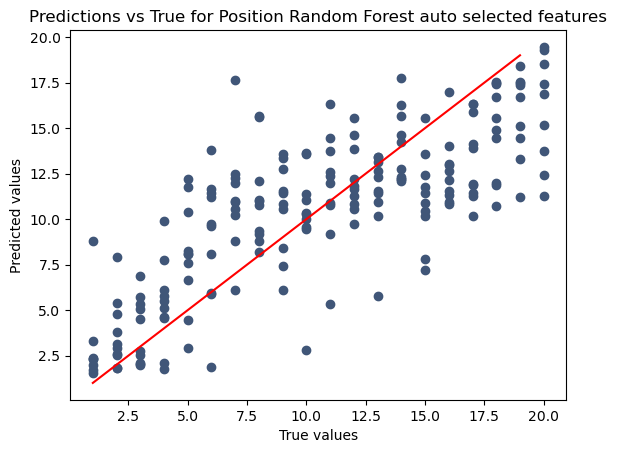

In [95]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Random Forest auto selected features')
plt.show()

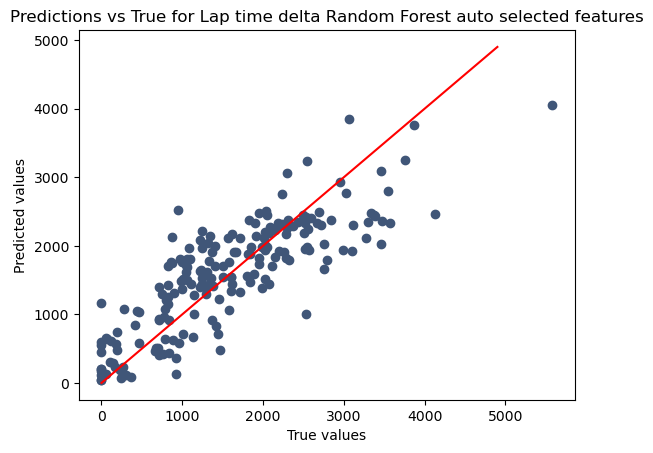

In [96]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest auto selected features')
plt.show()

## Optimise Lap time delta values manual features

In [43]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

random_forest_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('random_forest',RandomForestRegressor())# classifier
        
]
forest_pipe=Pipeline(random_forest_estimator)

In [44]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['squared_error', 'absolute_error', 'poisson'],
    'random_forest__max_depth':np.arange(5,100,10),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':[5,10,15,20,25,30,'sqrt','log2'],    
    'random_forest__oob_score':[True, False],
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=50,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'random_forest__oob_score': False, 'random_forest__n_estimators': 200, 'random_forest__min_samples_leaf': 1, 'random_forest__max_features': 20, 'random_forest__max_depth': 15, 'random_forest__criterion': 'poisson'}


In [45]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(150,250,10),
    'random_forest__criterion':['poisson'],
    'random_forest__max_depth':np.arange(5,30,5),
    'random_forest__min_samples_leaf': np.arange(1,10,2),
    'random_forest__max_features':np.arange(10,60,10),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ydelta_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 1250 candidates, totalling 6250 fits
{'random_forest__criterion': 'poisson', 'random_forest__max_depth': 20, 'random_forest__max_features': 30, 'random_forest__min_samples_leaf': 7, 'random_forest__n_estimators': 160}


In [46]:
results_rf_pos = pd.DataFrame({'Validation score':fittedgrid_rf.cv_results_['mean_test_score'],
'Train score':fittedgrid_rf.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_rf.cv_results_['param_random_forest__n_estimators'],
'max_depth_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_depth'],
'max_features_in_grid': fittedgrid_rf.cv_results_['param_random_forest__max_features'],
'min_samples_leaf_in_grid': fittedgrid_rf.cv_results_['param_random_forest__min_samples_leaf']})
results_rf_pos

,Validation score,Train score,n_estimators_in_grid,max_depth_in_grid,max_features_in_grid,min_samples_leaf_in_grid
0,0.213604,0.793772,150,5,10,1
1,0.280127,0.794233,160,5,10,1
2,0.225102,0.794551,170,5,10,1
3,0.260590,0.796988,180,5,10,1
4,0.208990,0.795312,190,5,10,1
...,...,...,...,...,...,...
1245,0.370768,0.752039,200,25,30,9
1246,0.341704,0.748557,210,25,30,9
1247,0.368302,0.750709,220,25,30,9
1248,0.325145,0.749322,230,25,30,9


In [47]:
print('Best Random Forest lap delta regression model accuracy_score on X test:',fittedgrid_rf.best_estimator_.score(X_test_manual, ydelta_test))

Best Random Forest lap delta regression model accuracy_score on X test: 0.6909437845956279


In [48]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_regression_model_lapdelta.pkl')

['pickled_best_RF_regression_model_lapdelta.pkl']

In [423]:
RF_best_lapdelta_model = joblib.load('pickled_best_RF_regression_model_lapdelta.pkl')

In [424]:
delta_predictions=RF_best_lapdelta_model.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.6909437845956279
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 307884.9576974179
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 433.46412779940755


In [425]:
Results_summary.append(pd.DataFrame({'Model':'Optimised RandomForest',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions)},index=[0]))

Text(0.5, 1.0, 'Predictions vs True for Lap time delta Random Forest optimised model')

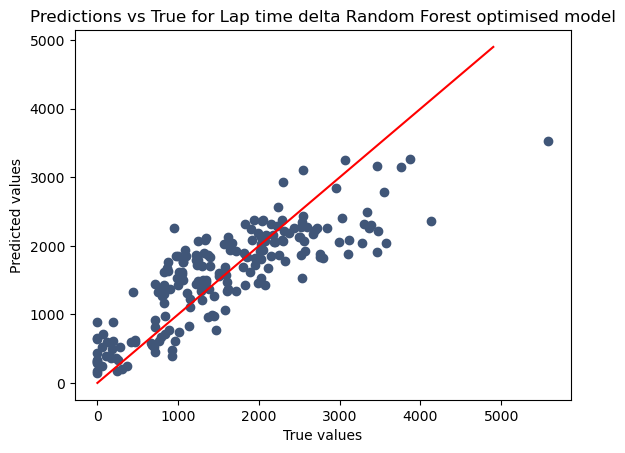

In [52]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Random Forest optimised model')
plt.show()

In [55]:
print(f'Number of features used in the model {len(fittedgrid_rf.best_estimator_[:-1].get_feature_names_out())}')

Number of features used in the model 74


In [64]:
RF_results = pd.DataFrame(data=fittedgrid_rf.best_estimator_['random_forest'].feature_importances_ ,index=fittedgrid_rf.best_estimator_['column_transform'].get_feature_names_out())

In [65]:
RF_results.rename(columns={0:'Random_forest_result'},inplace=True)

In [68]:
RF_results

,Random_forest_result
numerical_transform__circuit_max_straight,0.006052
numerical_transform__circuit_total_corner_curvature,0.007357
numerical_transform__circuit_mean_corner_curvature,0.013679
numerical_transform__circuit_max_corner_curvature,0.004337
numerical_transform__circuit_std_corner_curvature,0.004458
...,...
hot_encode__constructorRef_red_bull,0.036458
hot_encode__constructorRef_renault,0.000021
hot_encode__constructorRef_sauber,0.000168
hot_encode__constructorRef_toro_rosso,0.000180


<AxesSubplot: >

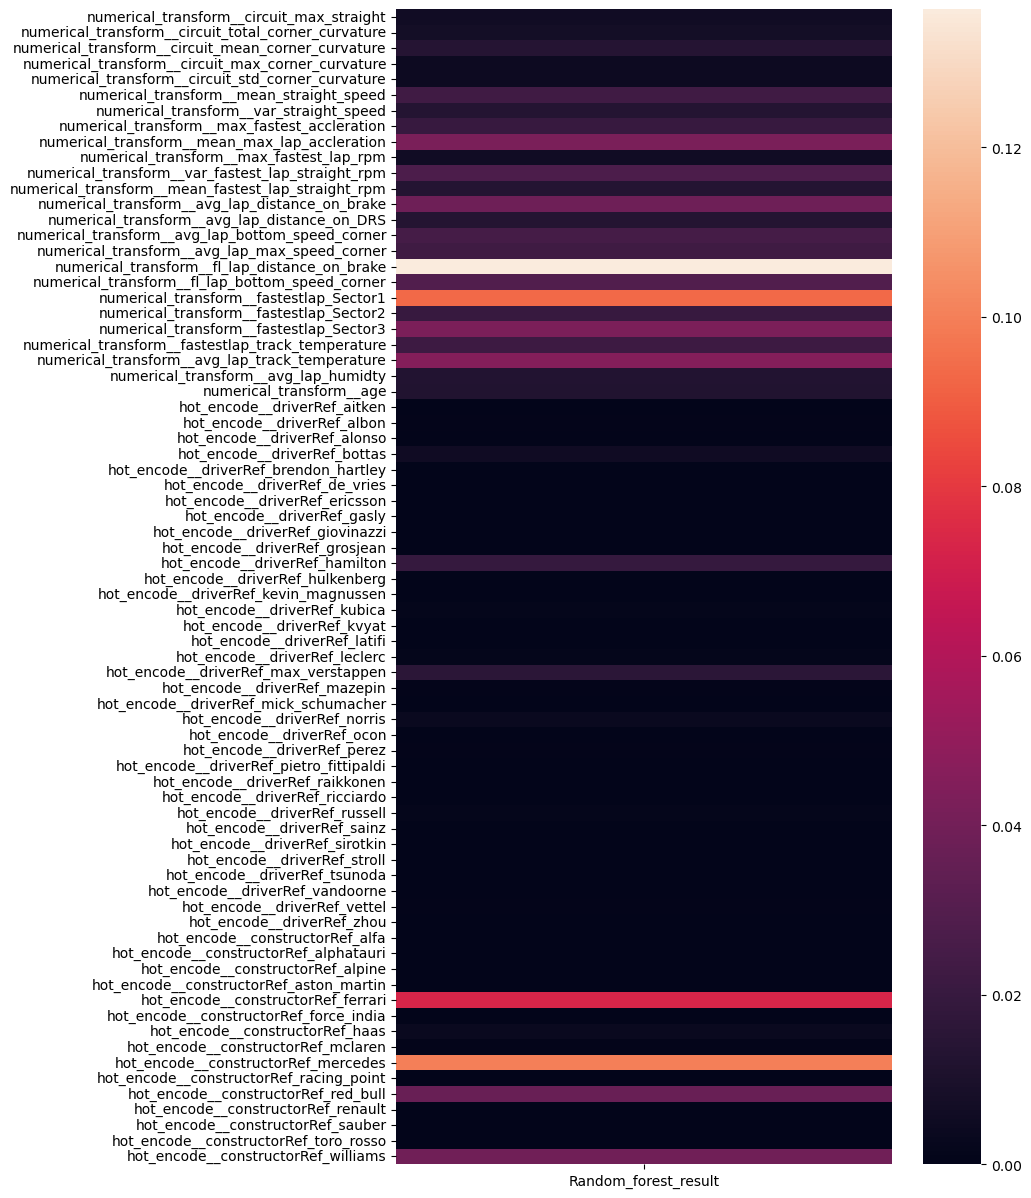

In [67]:
plt.figure(figsize=(8,15))
sns.heatmap(RF_results)

# Random Forest Optimise Qualifying Position

In [124]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(10,500,10),
    'random_forest__criterion':['squared_error', 'absolute_error', 'poisson'],
    'random_forest__max_depth':np.arange(5,50,5),
    'random_forest__min_samples_leaf': np.arange(1,50,5),
    'random_forest__max_features':np.arange(10,70,10),      
    }
   
]

grid_rf = RandomizedSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'random_forest__n_estimators': 380, 'random_forest__min_samples_leaf': 6, 'random_forest__max_features': 60, 'random_forest__max_depth': 35, 'random_forest__criterion': 'squared_error'}


In [125]:
print(fittedgrid_rf.best_params_)

{'random_forest__n_estimators': 380, 'random_forest__min_samples_leaf': 6, 'random_forest__max_features': 60, 'random_forest__max_depth': 35, 'random_forest__criterion': 'squared_error'}


In [127]:
pos_predictions=fittedgrid_rf.best_estimator_.predict(X_test_manual)
print(f'Position Random Forest regression R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position Random Forest regression R2 score with manual selected featuers 0.6334829245029117
Position Random Forest regression MSE score with manual selected feaure 11.793986352933963
Position Random Forest regression MAE score with manual selected feaure 2.6805307043265474


In [132]:
param_grid_rf =[
    
    #vary DT parameters only
    {
    'random_forest__n_estimators':np.arange(360,400,10),
    'random_forest__criterion':['squared_error'],
    'random_forest__max_depth':np.arange(30,51,5),
    'random_forest__min_samples_leaf': [6],
    'random_forest__max_features':np.arange(55,75,5),    
    }
   
]

grid_rf = GridSearchCV(forest_pipe, param_grid_rf, cv=5,verbose=1,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_rf = grid_rf.fit(X_train_manual, ypos_train)

print(fittedgrid_rf.best_params_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
{'random_forest__criterion': 'squared_error', 'random_forest__max_depth': 35, 'random_forest__max_features': 70, 'random_forest__min_samples_leaf': 6, 'random_forest__n_estimators': 380}


In [134]:
joblib.dump(fittedgrid_rf.best_estimator_, 'pickled_best_RF_regression_model_position.pkl')

['pickled_best_RF_regression_model_position.pkl']

In [426]:
RF_best_pos_model = joblib.load('pickled_best_RF_regression_model_position.pkl')

In [427]:
pos_predictions=RF_best_pos_model.predict(X_test_manual)
print(f'Position Random Forest regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position Random Forest regression Initial R2 score with manual selected featuers 0.6289464722175275
Position Random Forest regression Initial MSE score with manual selected feaure 11.939962788743927
Position Random Forest regression Initial MAE score with manual selected feaure 2.693308260056038


In [428]:
Results_summary.append(pd.DataFrame({'Model':'Optimised RandomForest',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions)},index=[0]))


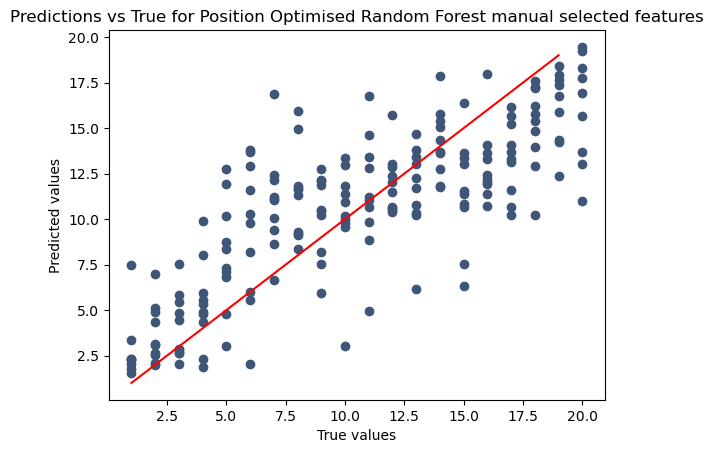

In [135]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Optimised Random Forest manual selected features')
plt.show()

## XGBoost Regressor

In [429]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

xgboost_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('xgboost',XGBRegressor())# classifier
        
]
xgb_pipe=Pipeline(xgboost_estimator)

In [430]:
xgb_pos= xgb_pipe.fit(X_train_manual,ypos_train)
pos_predictions=xgb_pos.predict(X_test_manual)
print(f'Position XGBoost regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')
xgb_delta= xgb_pipe.fit(X_train_manual,ydelta_train)
delta_predictions=xgb_delta.predict(X_test_manual)
print(f'Lap Delta XGBoost regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Position XGBoost regression Initial R2 score with manual selected featuers 0.6595529632527306
Position XGBoost regression Initial MAE score with manual selected feaure 2.5840383226774177
Lap Delta XGBoost regression Initial R2 score with manual selected featuers 0.7050872231366749
Lap Delta XGBoost regression Initial MAE score with manual selected feaure 434.1801664877911


In [431]:
Results_summary.append(pd.DataFrame({'Model':'Initial XGBoost',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions)},index=[0]))
Results_summary.append(pd.DataFrame({'Model':'Initial XGBoost',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions)},index=[0]))

In [386]:
print(f"Vanilla number of estimators {xgb_pipe['xgboost'].get_params()['n_estimators']}")
print(f"Vanilla depth of trees {xgb_pipe['xgboost'].get_params()['max_depth']}")
print(f"Vanilla learning rate {xgb_pipe['xgboost'].get_params()['learning_rate']}")

Vanilla number of estimators 100
Vanilla depth of trees 6
Vanilla learning rate 0.300000012


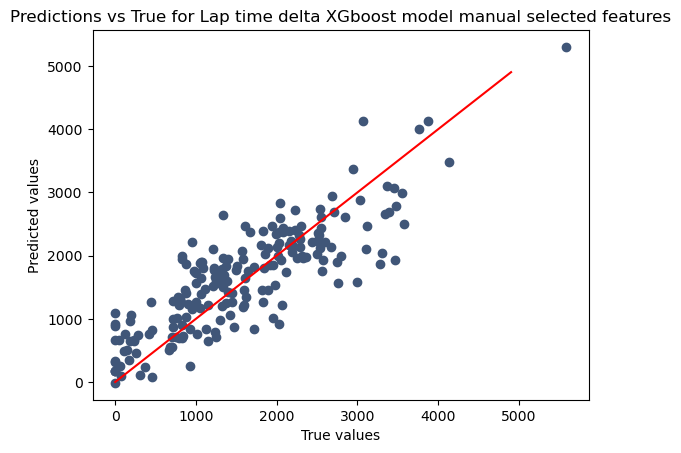

In [367]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta XGboost model manual selected features')
plt.show()

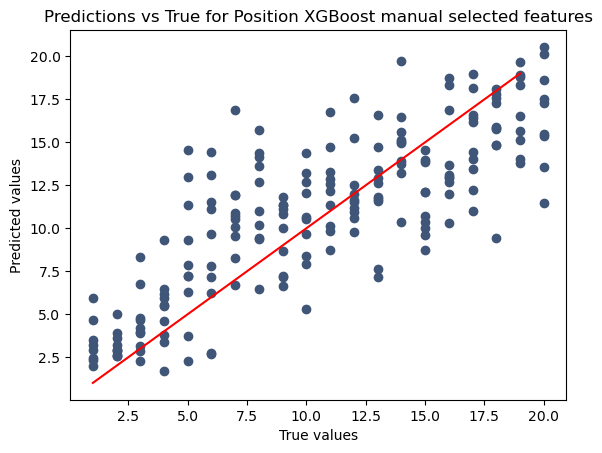

In [368]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position XGBoost manual selected features')
plt.show()

## Optimised XGboost for laptime delta

In [392]:
fold=5
print(f' validation size is {X_train_manual.shape[0]/fold}')
print(f'Train size is {X_train_manual.shape[0] - X_train_manual.shape[0]/fold} ')

 validation size is 339.0
Train size is 1356.0 


In [391]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,200,10),
    'xgboost__learning_rate':[0.1, 0.2, 0.3,0.4,0.5],
    'xgboost__max_depth':np.arange(1,10,2)   
    
    }
   
]

grid_xgb = RandomizedSearchCV(xgb_pipe, param_grid_xg, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb = grid_xgb.fit(X_train_manual, ydelta_train)

print(fittedgrid_xgb.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'xgboost__n_estimators': 60, 'xgboost__max_depth': 7, 'xgboost__learning_rate': 0.3}


In [393]:
param_grid_xgb =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,100,10),
    'xgboost__learning_rate':[0.3],
    'xgboost__max_depth':np.arange(5,10,1),

    
    }
   
]

grid_xgb_lap = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_lap = grid_xgb_lap.fit(X_train_manual, ydelta_train)

print(fittedgrid_xgb_lap.best_params_)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
{'xgboost__learning_rate': 0.3, 'xgboost__max_depth': 7, 'xgboost__n_estimators': 60}


In [394]:
results_xgb_delta = pd.DataFrame({'Validation score':fittedgrid_xgb_lap.cv_results_['mean_test_score'],
'Train score':fittedgrid_xgb_lap.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xgb_lap.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xgb_lap.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xgb_lap.cv_results_['param_xgboost__max_depth']
})
results_xgb_delta.head()

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,-1.514321,0.986860,50,0.3,5
1,-1.547816,0.990574,60,0.3,5
2,-1.558909,0.993245,70,0.3,5
3,-1.580060,0.995147,80,0.3,5
4,-1.585698,0.996401,90,0.3,5


In [395]:
# Save the best model
joblib.dump(fittedgrid_xgb_lap.best_estimator_, 'pickled_best_XGboost_regression_model_lap_delta.pkl')

['pickled_best_XGboost_regression_model_lap_delta.pkl']

In [433]:
XG_best_lapdelta_model = joblib.load('pickled_best_XGboost_regression_model_lap_delta.pkl')

In [434]:
delta_predictions=XG_best_lapdelta_model.predict(X_test_manual)
print(f'Lap Delta Random Forest regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Random Forest regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Random Forest regression Initial R2 score with manual selected featuers 0.7195158662512109
Lap Delta Random Forest regression Initial MSE score with manual selected feaure 279421.15818978986
Lap Delta Random Forest regression Initial MAE score with manual selected feaure 410.1674213895992


In [435]:
Results_summary.append(pd.DataFrame({'Model':'Optimised XGBoost',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions)},index=[0]))

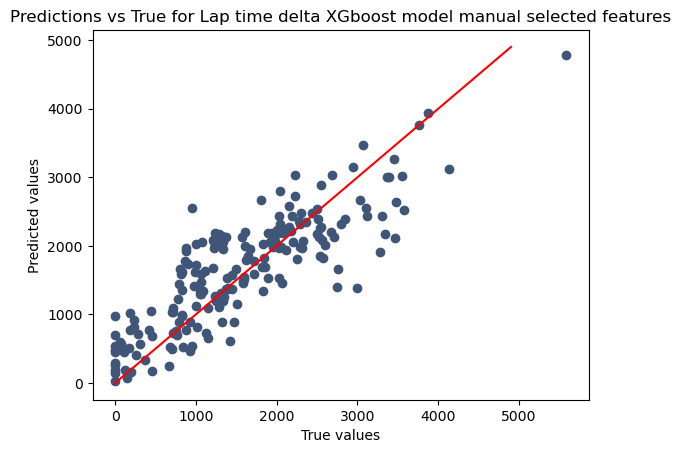

In [397]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta XGboost model manual selected features')
plt.show()

## Optimise XGBoost for position

In [399]:
param_grid_xg =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(50,200,10),
    'xgboost__learning_rate':[0.1, 0.2, 0.3,0.4,0.5],
    'xgboost__max_depth':np.arange(1,10,2)   
    }
   
]

grid_xgb_pos = RandomizedSearchCV(xgb_pipe, param_grid_xg, cv=5,verbose=1, n_iter=100,return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_pos = grid_xgb_pos.fit(X_train_manual, ypos_train)

print(fittedgrid_xgb_pos.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'xgboost__n_estimators': 60, 'xgboost__max_depth': 7, 'xgboost__learning_rate': 0.1}


In [400]:
param_grid_xgb =[
    
    #vary DT parameters only
    {
    'xgboost__n_estimators':np.arange(40,100,10),
    'xgboost__learning_rate':[0.1],
    'xgboost__max_depth':np.arange(5,10,1),

    
    }
   
]

grid_xgb_pos = GridSearchCV(xgb_pipe, param_grid_xgb, cv=5,verbose=1, return_train_score=True,n_jobs=-1) # cross validation fold of 5 20% validation per fold. N_iter 25 to limit random iteration to 25. 
fittedgrid_xgb_pos = grid_xgb_pos.fit(X_train_manual, ypos_train)

print(fittedgrid_xgb_pos.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'xgboost__learning_rate': 0.1, 'xgboost__max_depth': 5, 'xgboost__n_estimators': 50}


In [401]:
results_xgb_pos = pd.DataFrame({'Validation score':fittedgrid_xgb_pos.cv_results_['mean_test_score'],
'Train score':fittedgrid_xgb_pos.cv_results_['mean_train_score'],
'n_estimators_in_grid':fittedgrid_xgb_pos.cv_results_['param_xgboost__n_estimators'],
'learning_rate_in_grid': fittedgrid_xgb_pos.cv_results_['param_xgboost__learning_rate'],
'max_depth_in_grid': fittedgrid_xgb_pos.cv_results_['param_xgboost__max_depth']
})
results_xgb_delta.head()

,Validation score,Train score,n_estimators_in_grid,learning_rate_in_grid,max_depth_in_grid
0,-1.514321,0.986860,50,0.3,5
1,-1.547816,0.990574,60,0.3,5
2,-1.558909,0.993245,70,0.3,5
3,-1.580060,0.995147,80,0.3,5
4,-1.585698,0.996401,90,0.3,5


In [405]:
# Save the best model
joblib.dump(fittedgrid_xgb_pos.best_estimator_, 'pickled_best_XGboost_regression_model_position.pkl')

['pickled_best_XGboost_regression_model_position.pkl']

In [436]:
XG_best_position_model = joblib.load('pickled_best_XGboost_regression_model_position.pkl')

In [437]:
pos_predictions=XG_best_position_model.predict(X_test_manual)
print(f'Position XGBoost regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position XGBoost regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position XGBoost regression Initial R2 score with manual selected featuers 0.6334127260106219
Position XGBoost regression Initial MSE score with manual selected feaure 11.79624523830496
Position XGBoost regression Initial MAE score with manual selected feaure 2.792230034969291


In [438]:
Results_summary.append(pd.DataFrame({'Model':'Optmised XGBoost',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions)},index=[0]))


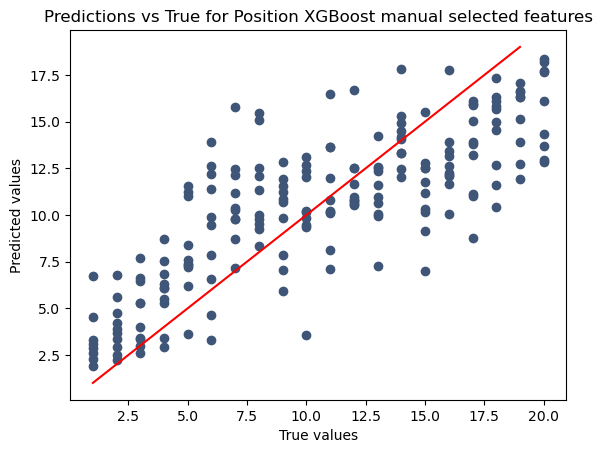

In [404]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position XGBoost manual selected features')
plt.show()

## Simple Neural Network

In [150]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasRegressor

In [220]:
X_train_manual_split, X_val_manual, ydelta_train_split, ydelta_val = train_test_split(X_train_manual,ydelta_train,test_size=0.2,random_state=123)

In [440]:
def create_model():
    # Create a new sequential model
    model = keras.Sequential()

    regularizer = keras.regularizers.l2(0.01)

    # Declare the hidden layers
    
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(100, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation="relu", kernel_regularizer=regularizer))
    model.add(Dropout(0.2))
    model.add(Dense(25, activation="relu", kernel_regularizer=regularizer))
    
    # Declare the output layer
    model.add(Dense(1)) # For regression, we don't specify any activation function.

    # Compile the model
    model.compile(
        # Optimizer
        optimizer=keras.optimizers.Adam(),  
        # Loss function to minimize
        loss=keras.losses.MeanAbsoluteError()
    )
    return model

In [446]:
# set stopping criteria
callbacks = EarlyStopping(monitor='loss', min_delta=0.05, patience=10)
clf = KerasRegressor(build_fn=create_model,epochs=400, verbose=0,callbacks=[callbacks])

In [447]:

transformer =[('numerical_transform',StandardScaler(),scale_cols),
('hot_encode',OneHotEncoder(handle_unknown="ignore"),hot_encode_col)
]

nueral_network_estimator=[('column_transform',ColumnTransformer(transformers=transformer)),    
        ('nueral_network',clf)# classifier
        
]
nn_pipe=Pipeline(nueral_network_estimator)

In [352]:
X_train_manual_split_array=nn_pipe['column_transform'].fit_transform(X_train_manual_split)
X_val_manual_array=nn_pipe['column_transform'].transform(X_val_manual)

In [353]:
history=nn_pipe['nueral_network'].fit(X_train_manual_split_array,ydelta_train_split.values, validation_data=(X_val_manual_array,ydelta_val.values))

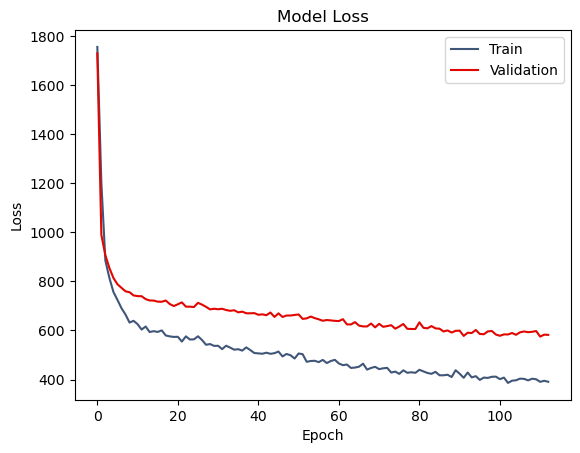

In [354]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'])
plt.show()

In [443]:
history = nn_pipe.fit(X_train_manual,ydelta_train)

In [444]:
delta_predictions=history.predict(X_test_manual)
print(f'Lap Delta Neural Network regression Initial R2 score with manual selected featuers {r2_score(ydelta_test,delta_predictions)}')
print(f'Lap Delta Neural Network regression Initial MSE score with manual selected feaure {mean_squared_error(ydelta_test,delta_predictions)}')
print(f'Lap Delta Neural Network regression Initial MAE score with manual selected feaure {mean_absolute_error(ydelta_test,delta_predictions)}')

Lap Delta Neural Network regression Initial R2 score with manual selected featuers 0.5106346253675766
Lap Delta Neural Network regression Initial MSE score with manual selected feaure 487510.78333806986
Lap Delta Neural Network regression Initial MAE score with manual selected feaure 517.3526691903874


In [445]:
Results_summary.append(pd.DataFrame({'Model':'Neural Network',
'Target': 'LapDelta',
'R2':r2_score(ydelta_test,delta_predictions),
'MSE':mean_squared_error(ydelta_test,delta_predictions),
'MAE':mean_absolute_error(ydelta_test,delta_predictions)},index=[0]))

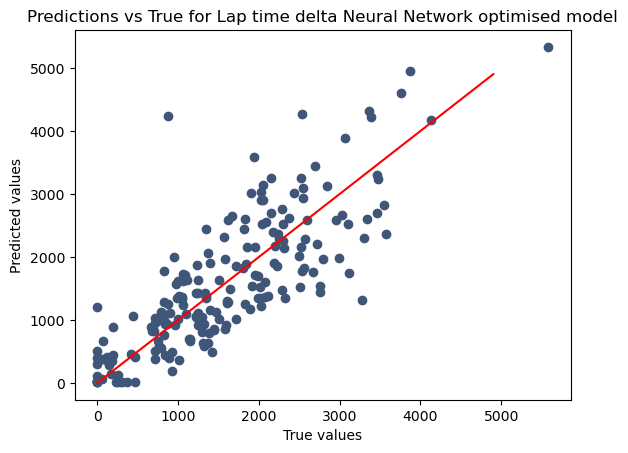

In [364]:
plt.scatter(ydelta_test,delta_predictions)
plt.plot(np.arange(1,5000,100),np.arange(1,5000,100),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Lap time delta Neural Network optimised model')
plt.show()

In [448]:
history = nn_pipe.fit(X_train_manual,ypos_train)
pos_predictions=history.predict(X_test_manual)
print(f'Position Neural Network regression Initial R2 score with manual selected featuers {r2_score(ypos_test,pos_predictions)}')
print(f'Position Neural Network regression Initial MSE score with manual selected feaure {mean_squared_error(ypos_test,pos_predictions)}')
print(f'Position Neural Network regression Initial MAE score with manual selected feaure {mean_absolute_error(ypos_test,pos_predictions)}')

Position Neural Network regression Initial R2 score with manual selected featuers 0.6517573319040554
Position Neural Network regression Initial MSE score with manual selected feaure 11.205942504759266
Position Neural Network regression Initial MAE score with manual selected feaure 2.5330803722751383


In [449]:
Results_summary.append(pd.DataFrame({'Model':'Neural Network',
'Target': 'Position',
'R2':r2_score(ypos_test,pos_predictions),
'MSE':mean_squared_error(ypos_test,pos_predictions),
'MAE':mean_absolute_error(ypos_test,pos_predictions)},index=[0]))

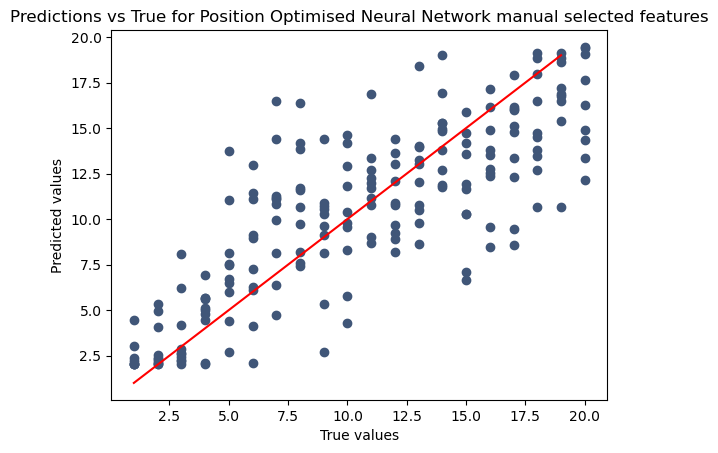

In [450]:
plt.scatter(ypos_test,pos_predictions)
plt.plot(np.arange(1,20,1),np.arange(1,20,1),c='r')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True for Position Optimised Neural Network manual selected features')
plt.show()

In [453]:
Regression_model_summary = pd.concat(Results_summary)

In [454]:
Regression_model_summary.reset_index(drop=True,inplace=True)

In [456]:
Position_summary = Regression_model_summary[Regression_model_summary['Target'] == 'Position']
Lapdelta_summary = Regression_model_summary[Regression_model_summary['Target'] == 'LapDelta']

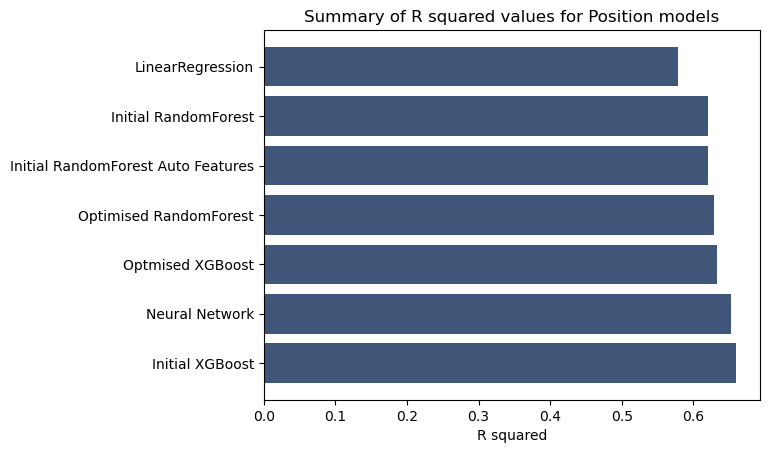

In [477]:
Position_summary.sort_values(by='R2',ascending=False,inplace=True)
plt.barh(Position_summary['Model'],Position_summary['R2'])
plt.title('Summary of R squared values for Position models')
plt.xlabel('R squared')
plt.show()


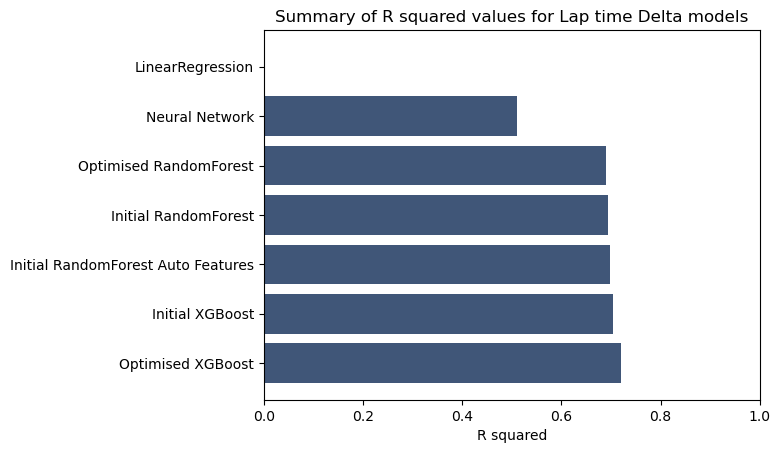

In [478]:
Lapdelta_summary.sort_values(by='R2',ascending=False,inplace=True)
plt.barh(Lapdelta_summary['Model'],Lapdelta_summary['R2'])
plt.xlim(0,1)
plt.title('Summary of R squared values for Lap time Delta models')
plt.xlabel('R squared')
plt.show()

In [476]:
Regression_model_summary.to_pickle('./data/model_data/regression_model_summary.pkl',compression='gzip')